In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import time as time
from numpy.linalg import inv
from lib.simubot import hom, loc,simubot
from lib.dibrobot import dibrobot
from lib.utils import c2m, polares, distancia_angular

In [2]:
def escenario():
   # Escenario
    plt.vlines(0, 0, 3.2, colors='k',lw=1.5)
    plt.vlines(1.2, 0.8, 3.2, colors='k',lw=1.5)
    plt.vlines(2.8, 0, 3.2, colors='k',lw=1.5)
    plt.hlines(0, 0, 2.8, colors='k',lw=1.5)
    plt.hlines(3.2, 0, 0.4, colors='k',lw=1.5)
    plt.hlines(3.2, 0.8, 1.2, colors='k',lw=1.5)
    plt.hlines(3.2, 1.6, 2.4, colors='k',lw=1.5)
    plt.hlines(1.2, 1.6, 2.4, colors='k',lw=1.5)
    # Grid
    plt.hlines(0.4, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.hlines(0.8, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.hlines(1.2, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.hlines(1.6, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.hlines(2.0, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.hlines(2.4, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.hlines(2.8, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.hlines(3.2, 0, 2.8, colors='k',ls='--',lw=0.5)
    plt.vlines(0.4, 0, 3.2, colors='k',ls='--',lw=0.5)
    plt.vlines(0.8, 0, 3.2, colors='k',ls='--',lw=0.5)
    plt.vlines(1.2, 0, 3.2, colors='k',ls='--',lw=0.5)
    plt.vlines(1.6, 0, 3.2, colors='k',ls='--',lw=0.5)
    plt.vlines(2, 0, 3.2, colors='k',ls='--',lw=0.5)
    plt.vlines(2.4, 0, 3.2, colors='k',ls='--',lw=0.5)
    plt.vlines(2.8, 0, 3.2, colors='k',ls='--',lw=0.5)
    # Cuadros
    plt.vlines(0, 1.4, 1.8, colors='b',lw=4)
    plt.hlines(0, 0.4, 0.8, colors='b',lw=4)
    plt.hlines(3.2, 1.8, 2.2, colors='b',lw=4)

    plt.gca().set_aspect('equal', adjustable='box')



def simumovil(wXm, pasos_m, T, i, par_m):
    global v_hist_m, w_hist_m
    [kp, ka, kb] = par_m
    assert kp > 0, 'kp del movil debe ser mayorque 0'
    assert kb > 0, 'ka del movil debe ser mayor que 0'
    assert ka-kb > 0, 'ka-kb del movil debe ser mayor que 0'
    K = [[kp,0,0], [0,ka,kb]]

    if i == -1:
        return wXm, i

    paso = pasos_m[i]

    wXg = [paso[0], paso[1], paso[2]]
    gXr = loc(np.dot(inv(hom(wXg)),hom(wXm)))

    gPr = polares(gXr[0], gXr[1], gXr[2])

    [v,w]= np.dot(K, gPr)
    v_hist_m.append(v)
    w_hist_m.append(w)
    
    wXm = simubot([v,w], wXm, T)
    
    if gPr[0] < 0.1:
        i = i + 1
        if i == len(pasos_m):
            i = -1
    
    return wXm, i

v_hist_m = []
w_hist_m = []

v_hist_r = []
w_hist_r = []

Se chocaron


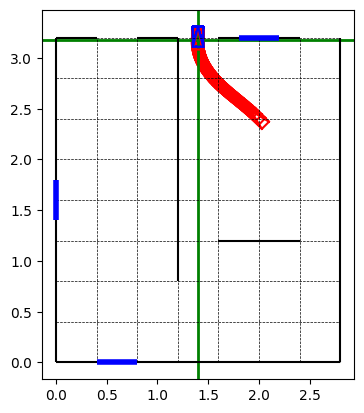

In [15]:
def tracking(par_r, par_m, wXrInicial=[2.0, 2.4, 3*np.pi/4], distancia=0.03):
    global v_hist_r, w_hist_r, v_hist_m, w_hist_m
    v_hist_r = []
    w_hist_r = []
    v_hist_m = []
    w_hist_m = []

    [kp, ka, kb] = par_r
    assert kp > 0, 'kp del robot debe ser mayorque 0'
    assert kb > 0, 'ka del robot debe ser mayor que 0'
    assert ka-kb > 0, 'ka-kb del robot debe ser mayor que 0'
    
    T = 0.1
        
    K = [[kp,0,0],[0,ka,kb]]
    pasos_m = [
        [c2m(3)+.2,c2m(8),np.pi/2],
        [],
    ]
    wXm = [c2m(3)+.2,c2m(8),np.pi/2]
    wXr = wXrInicial
    i = 0
    dibrobot(wXm, 'b', 'p')
    dibrobot(wXr, 'r', 'p')

    while True:
        # wXm, i = simumovil(wXm, pasos_m, T, i, par_m)

        mXr = loc(np.dot(inv(hom(wXm)),hom(wXr)))
        mPr = polares(mXr[0], mXr[1], mXr[2])

        [v,w]= np.dot(K, mPr)
        v_hist_r.append(v)
        w_hist_r.append(w)
        
        wXr = simubot([v,w], wXr, T)
        dibrobot(wXr, 'r', 'p')
        dibrobot(wXm, 'b', 'p')
        # break

        if mPr[0] < distancia and distancia_angular(wXm[2], wXr[2]) < np.deg2rad(2) or mPr[1] > 3.4:
            print('Se chocaron')
            # draw x and y lines in the plot
            plt.axhline(wXr[1], color='green', lw=2)
            plt.axvline(wXr[0], color='green', lw=2)
            break
        
        if i == -1:
            break

    dibrobot(wXr, 'r', 'p')
    dibrobot(wXm, 'b', 'p')
    escenario()

# antes de P1
tracking(par_r=[0.5, 1.5, 0.8], par_m = None)

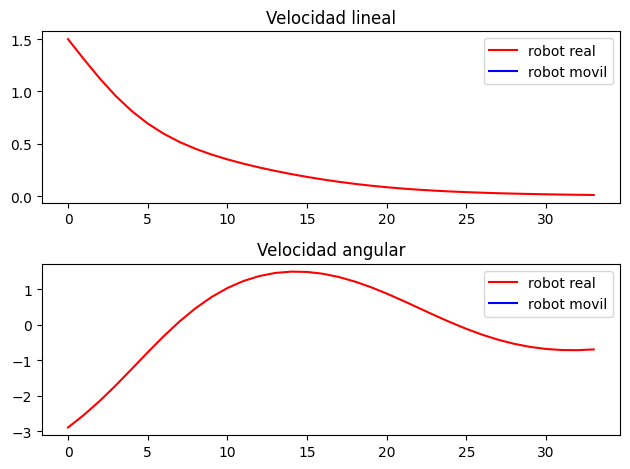

In [43]:
fig, ax = plt.subplots(2,1)

ax[0].plot(v_hist_r, label='robot real', color='r')
ax[0].plot(v_hist_m, label='robot movil', color='b')
ax[0].legend()
ax[0].set_title('Velocidad lineal')

ax[1].plot(w_hist_r, label='robot real', color='r')
ax[1].plot(w_hist_m, label='robot movil', color='b')
ax[1].legend()
ax[1].set_title('Velocidad angular')

plt.tight_layout()
plt.show()

Se chocaron


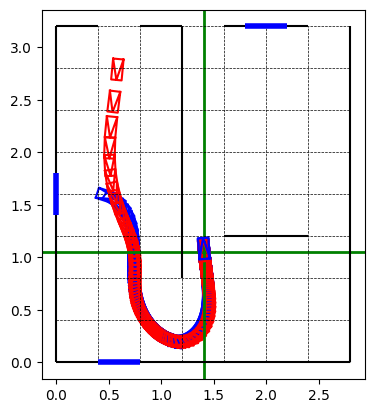

In [ ]:
# apartado 2
# entre P1 y P2
tracking(par_r=[.99, 1.4, 0.2], par_m=[0.19, 0.8, 0.4])